In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [174]:
team_data= pd.read_csv("team_data.csv")

In [175]:
#team_data['SystemName'].value_counts().head(100)
team_data['SystemName'].value_counts().head(10)#.loc['BPI']
#team_data[team_data['SystemName']=="BPI"]

POM    1197
MOR    1197
SAG    1197
COL    1197
DOL    1197
WLK    1197
WOB    1132
BIH    1132
RTH    1130
WOL    1130
Name: SystemName, dtype: int64

<AxesSubplot:xlabel='T_Wins', ylabel='OrdinalRank'>

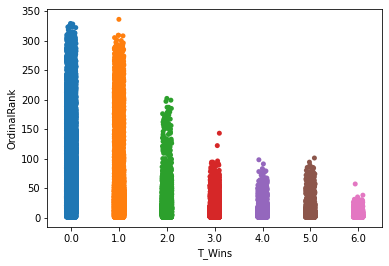

In [176]:
sns.stripplot(data=team_data, x = 'T_Wins', y='OrdinalRank')

In [177]:
import warnings
warnings.filterwarnings('ignore')

In [178]:
team_data['T_Wins'].value_counts()

0.0    29558
1.0    16691
2.0     7533
3.0     3977
4.0     1727
5.0      997
6.0      956
Name: T_Wins, dtype: int64

In [7]:
#pip install -U imbalanced-learn

In [179]:
from imblearn.over_sampling import RandomOverSampler

In [180]:
sampler = RandomOverSampler()

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [182]:
from sklearn.model_selection import cross_val_score

In [183]:
models = [MultinomialNB(), RandomForestClassifier(n_estimators=100), KNeighborsClassifier(n_neighbors=17), svm.SVC(kernel='linear'), LogisticRegression(solver='lbfgs')]


In [184]:
#systems = list(team_data['SystemName'].value_counts().head(2).index)
#systems

In [185]:
#for system in systems:
#    name=str(system)
#    df = team_data[team_data['SystemName']==system]
    #print(sns.heatmap(df.corr()[['T_Wins']], annot=True))
    #X = df['OrdinalRank'] #.array().reshape(-1, 1)
    #X = np.reshape(list(X), (X.shape[0],1))
    #y = df['T_Wins']
    #y = np.reshape(list(y), (y.shape[0],1))
    #X , y = sampler.fit_resample(X,y)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    #model=MultinomialNB()
#    model=RandomForestClassifier(n_estimators=100)
    #model=KNeighborsClassifier(n_neighbors=17)
    #model=svm.SVC(kernel='linear')
    #model=LogisticRegression(solver='lbfgs')
#    model.fit(X_train, y_train)
#    y_predict=model.predict(X_test)
#    ac=accuracy_score(y_predict,y_test)
#    cm=confusion_matrix(y_test, y_predict)
#    cr=classification_report(y_test, y_predict)
#    print(f'{system }Train Score: {model.score(X_train, y_train)}')
#    print(f'{system }Test Score: {model.score(X_test, y_test)}')
#    print(f'{system }Accuracy: {ac}')
#    print(f'{system }Confusion Matrix: \n {cm}')
#    print(f'{system }Classification Report: \n {cr}')

In [186]:
system = 'POM'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [187]:
model_selection_rank1 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank1[model.__str__()] = scores
model_selection_rank1

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.449477,0.421603,0.275261,0.308362
1,0.151832,0.434555,0.403141,0.256545,0.265271
2,0.151832,0.476440,0.436300,0.265271,0.291449
3,0.151832,0.474695,0.429319,0.272251,0.310646
4,0.153578,0.434555,0.410122,0.275742,0.286213


In [188]:
system = 'SAG'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [189]:
model_selection_rank2 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank2[model.__str__()] = scores
model_selection_rank2

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.419861,0.419861,0.278746,0.290941
1,0.151832,0.411867,0.380454,0.286213,0.301920
2,0.151832,0.401396,0.382199,0.307155,0.282723
3,0.151832,0.429319,0.424084,0.314136,0.319372
4,0.153578,0.427574,0.389180,0.284468,0.303665


In [190]:
system = 'MOR'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [191]:
model_selection_rank3 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank3[model.__str__()] = scores
model_selection_rank3

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.388502,0.390244,0.296167,0.331010
1,0.151832,0.429319,0.417103,0.273997,0.294939
2,0.151832,0.434555,0.382199,0.300175,0.321117
3,0.151832,0.431065,0.385689,0.291449,0.294939
4,0.153578,0.415358,0.371728,0.289703,0.275742


In [192]:
system = 'COL'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [193]:
model_selection_rank4 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank4[model.__str__()] = scores
model_selection_rank4

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.454704,0.383275,0.277003,0.306620
1,0.151832,0.452007,0.439791,0.246073,0.280977
2,0.151832,0.446771,0.427574,0.275742,0.294939
3,0.151832,0.434555,0.441536,0.282723,0.333333
4,0.153578,0.455497,0.413613,0.246073,0.265271


In [194]:
system = 'DOL'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [196]:
model_selection_rank5 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank5[model.__str__()] = scores
model_selection_rank5

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.473868,0.407666,0.283972,0.297909
1,0.151832,0.450262,0.434555,0.300175,0.314136
2,0.151832,0.460733,0.439791,0.287958,0.305410
3,0.151832,0.481675,0.441536,0.312391,0.328098
4,0.153578,0.467714,0.417103,0.275742,0.282723


In [197]:
system = 'WLK'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [198]:
model_selection_rank6 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank6[model.__str__()] = scores
model_selection_rank6

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151568,0.405923,0.358885,0.306620,0.297909
1,0.151832,0.422339,0.403141,0.277487,0.291449
2,0.151832,0.366492,0.373473,0.286213,0.301920
3,0.151832,0.385689,0.345550,0.307155,0.291449
4,0.153578,0.401396,0.380454,0.307155,0.308901


In [199]:
system = 'MAS'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [200]:
model_selection_rank7 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank7[model.__str__()] = scores
model_selection_rank7

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.151786,0.488839,0.430804,0.303571,0.332589
1,0.149554,0.457589,0.426339,0.321429,0.341518
2,0.149554,0.473214,0.439732,0.328125,0.292411
3,0.151786,0.468750,0.417411,0.299107,0.292411
4,0.152125,0.480984,0.440716,0.290828,0.290828


#### ESPN's BPI is a popular predictive ranking system. We can see it scores better than the other popular models we tried. However, we will not consider using BPI as we only have data from 2009 to 2013. Future work includes to complete this data and see if the predictive performance holds true.


In [201]:
system = 'BPI'
df = team_data[team_data['SystemName']==system]
X = df['OrdinalRank']#.array().reshape(-1, 1)
X = np.reshape(list(X), (X.shape[0],1))
y = df['T_Wins']
y = np.reshape(list(y), (y.shape[0],1))
X , y = sampler.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [202]:
model_selection_rank8 = pd.DataFrame()
for model in models:
    scores = cross_val_score(model, X_train, y_train)
    model_selection_rank8[model.__str__()] = scores
model_selection_rank8

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
0,0.143750,0.681250,0.618750,0.275000,0.331250
1,0.150000,0.706250,0.650000,0.312500,0.337500
2,0.150000,0.737500,0.650000,0.275000,0.318750
3,0.150943,0.666667,0.591195,0.320755,0.345912
4,0.150943,0.679245,0.628931,0.257862,0.276730


#### Check scores of the selected rating systems to confirm adequacy in our predictive model. 

In [235]:
list_of_max_entries = list(x.index[x['SystemName']==team_data['SystemName'].value_counts().max()])
systems = list_of_max_entries
systems.append('MAS')
systems

['POM', 'MOR', 'SAG', 'COL', 'DOL', 'WLK', 'MAS']

In [236]:
for system in systems:
    name=str(system)
    df = team_data[team_data['SystemName']==system]
    #print(sns.heatmap(df.corr()[['T_Wins']], annot=True))
    X = df['OrdinalRank'] #.array().reshape(-1, 1)
    X = np.reshape(list(X), (X.shape[0],1))
    y = df['T_Wins']
    y = np.reshape(list(y), (y.shape[0],1))
    X , y = sampler.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    y_predict=model.predict(X_test)
    ac=accuracy_score(y_predict,y_test)
    cm=confusion_matrix(y_test, y_predict)
    cr=classification_report(y_test, y_predict)
    print(f'{system }Train Score: {model.score(X_train, y_train)}')
    print(f'{system }Test Score: {model.score(X_test, y_test)}')
    print(f'{system }Accuracy: {ac}')
    print(f'{system }Confusion Matrix: \n {cm}')
    print(f'{system }Classification Report: \n {cr}')

POMTrain Score: 0.5024424284717376
POMTest Score: 0.45890968266883647
POMAccuracy: 0.45890968266883647
POMConfusion Matrix: 
 [[ 85  29  31   8  14  10   3]
 [ 35  54  29  15  22  12  20]
 [  3  14  61   5  34  15  30]
 [  0   2  32  21  27  21  46]
 [  0   7  11   0  96   9  51]
 [  0   0  12  11  18 108  49]
 [  0   0  16   0   8  16 139]]
POMClassification Report: 
               precision    recall  f1-score   support

         0.0       0.69      0.47      0.56       180
         1.0       0.51      0.29      0.37       187
         2.0       0.32      0.38      0.34       162
         3.0       0.35      0.14      0.20       149
         4.0       0.44      0.55      0.49       174
         5.0       0.57      0.55      0.56       198
         6.0       0.41      0.78      0.54       179

    accuracy                           0.46      1229
   macro avg       0.47      0.45      0.44      1229
weighted avg       0.48      0.46      0.44      1229

MORTrain Score: 0.4874389392882

In [237]:
#team_data_clean = team_data[team_data['SystemName']=='POM']

In [238]:
#team_data_clean.drop(["Unnamed: 0", "SystemName", "RankingDayNum"], axis=1, inplace=True)

In [239]:
#team_data_clean

In [240]:
#team_data_clean.rename(columns = {'OrdinalRank': 'OrdinalRank_POM'}, inplace=True)

In [241]:
#team_data_clean.to_csv('team_data_clean.csv')

In [71]:
#team_data[team_data.groupby('SystemName')['SystemName'].count()==1197]

In [242]:
team_data['SystemName'].value_counts().max()

1197

In [243]:
x = pd.DataFrame(team_data['SystemName'].value_counts())
list_of_max_entries = list(x.index[x['SystemName']==team_data['SystemName'].value_counts().max()])

In [113]:
filtered_rankings = team_data[team_data.SystemName.isin(list_of_max_entries)]

In [131]:
filtered_rankings

,Unnamed: 0,Season,Seed,TeamID,TeamName,RankingDayNum,SystemName,OrdinalRank,Wins,Losses,Win%,T_Wins
5,5,2003,1,1328,Oklahoma,133,COL,3,24,6,80.0000,3.0
6,6,2003,1,1328,Oklahoma,133,DOL,6,24,6,80.0000,3.0
19,19,2003,1,1328,Oklahoma,133,MOR,6,24,6,80.0000,3.0
20,20,2003,1,1328,Oklahoma,133,POM,9,24,6,80.0000,3.0
23,23,2003,1,1328,Oklahoma,133,SAG,8,24,6,80.0000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61398,61398,2021,16,1216,Hartford,133,DOL,156,15,8,65.2174,0.0
61416,61416,2021,16,1216,Hartford,133,MOR,146,15,8,65.2174,0.0
61421,61421,2021,16,1216,Hartford,133,POM,189,15,8,65.2174,0.0
61426,61426,2021,16,1216,Hartford,133,SAG,186,15,8,65.2174,0.0


In [261]:
team_data_clean = filtered_rankings
for system in list_of_max_entries:
    entry = filtered_rankings[filtered_rankings['SystemName']==system][['Season', 'TeamID', 'OrdinalRank']]
    entry = entry.rename(columns={'OrdinalRank':(f'Rank_{system}')})
    team_data_clean = entry.merge(team_data_clean, how='inner', on=['TeamID', 'Season']) 
    #team_data_clean = team_data_clean.drop(['SystemName','OrdinalRank', 'Unnamed: 0'], axis=1)
team_data_clean.drop(['SystemName','OrdinalRank', 'Unnamed: 0', 'RankingDayNum'], axis=1, inplace=True)

In [264]:
team_data_clean.drop_duplicates(inplace=True)

In [265]:
team_data_clean.to_csv('team_data_clean.csv')